In [1]:
import pybamm
import numpy as np 
from numpy import pi
import matplotlib.pyplot as plt 

In [2]:
# parameters 
N = 20
r0 = 0.25
eps = (1-r0)/N
delta = 0.05
V = 1
sigma_a = 1
sigma_cc = 5*1e6
sigma = sigma_a / sigma_cc / eps**4 

In [3]:
# model
model = pybamm.BaseModel()
r = pybamm.SpatialVariable("radius", domain="radius", coord_sys="cylindrical polar")
phi_n = pybamm.Variable("Negative potential", domain="radius")
phi_p = pybamm.Variable("Positive potential", domain="radius")

A = 8 * pi **2 *sigma / delta / (1-4*delta)
# 1/r d(1/r  d\phi^+/dr)/dr = -8 \pi^2 \sigma (\phi^- - \phi^+) / \delta(1 - 4\delta)
# 1/r d(1/r  d\phi^-/dr)/dr =  8 \pi^2 \sigma (\phi^- - \phi^+) / \delta(1 - 4\delta)
# Note: in cylindrical polars 1/r d(1/r dphi/dr) = div(1/r^2 grad(phi))
model.algebraic = {
        phi_p: pybamm.div((1 / r ** 2) * pybamm.grad(phi_p)) + A * (phi_n - phi_p),
        phi_n: pybamm.div((1 / r ** 2) * pybamm.grad(phi_n)) - A * (phi_n - phi_p),
}
model.boundary_conditions = {
    phi_p: {
        "left": (0, "Neumann"),
        "right": (V, "Dirichlet"),
    },
    phi_n: {
        "left": (0, "Dirichlet"),
        "right": (0, "Neumann"),
    }    
}
model.initial_conditions = {phi_p: V, phi_n: 0}  # initial guess for solver
model.variables = {"Negative potential": phi_n, "Positive potential": phi_p}

In [4]:
# geometry
geometry = {"radius": {r: {"min": r0, "max": 1}}}

In [5]:
# discretisation
submesh_types = {"radius": pybamm.Uniform1DSubMesh}
var_pts = {r: 100}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
spatial_methods = {"radius": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model);

In [6]:
# solver 
solver = pybamm.CasadiAlgebraicSolver()
solution = solver.solve(model)

In [7]:
# post-process homogenised potential 
phi_n = solution["Negative potential"]
phi_p = solution["Positive potential"]

def alpha(r):
    return 2 * (phi_n(x=r) - phi_p(x=r))


def phi_am1(r, theta):
    # careful here - phi always returns a column vector so we need to add a new axis to r to get the right shape 
    return alpha(r) * (r[:,np.newaxis]/eps - r0/eps - delta - theta / 2 / pi) / (1 - 4*delta) + phi_p(x=r)

def phi_am2(r, theta):
    # careful here - phi always returns a column vector so we need to add a new axis to r to get the right shape 
    return alpha(r) * (r0/eps + 1 - delta + theta / 2 / pi - r[:,np.newaxis]/eps) / (1 - 4*delta) + phi_p(x=r)



2021-11-24 10:10:47,443 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for radius. Using default of 1 [m].
2021-11-24 10:10:47,446 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for radius. Using default of 1 [m].


In [8]:
# define spiral 
spiral_pos_inner = lambda t : r0 - eps * delta + eps * t / (2 * pi)
spiral_pos_outer = lambda t : r0 + eps * delta + eps * t / (2 * pi)

spiral_neg_inner = lambda t : r0 - eps * delta + eps/2 + eps * t / (2 * pi)
spiral_neg_outer = lambda t : r0 + eps * delta + eps/2 + eps * t / (2 * pi)

spiral_am1_inner = lambda t : r0 + eps * delta + eps * t / (2 * pi)
spiral_am1_outer = lambda t : r0 - eps * delta + eps/2 + eps * t / (2 * pi)

spiral_am2_inner = lambda t : r0 + eps * delta + eps/2 + eps * t / (2 * pi)
spiral_am2_outer = lambda t : r0 - eps * delta + eps + eps * t / (2 * pi)

In [9]:
# Setup fine mesh with nr points per layer
nr = 10
rr = np.linspace(r0, 1, nr)
tt = np.arange(0, (N+1)*2*pi, 2*pi)

# N+1 winds of pos c.c.
r_mesh_pos = np.zeros((len(tt),len(rr)))
for i in range(len(tt)):
    r_mesh_pos[i,:] = np.linspace(spiral_pos_inner(tt[i]), spiral_pos_outer(tt[i]), nr)
# N winds of neg, am1, am2
r_mesh_neg = np.zeros((len(tt)-1, len(rr)))
r_mesh_am1 = np.zeros((len(tt)-1, len(rr)))
r_mesh_am2 = np.zeros((len(tt)-1, len(rr)))
for i in range(len(tt)-1):
    r_mesh_am2[i,:] = np.linspace(spiral_am2_inner(tt[i]), spiral_am2_outer(tt[i]), nr)
    r_mesh_neg[i,:] = np.linspace(spiral_neg_inner(tt[i]), spiral_neg_outer(tt[i]), nr)
    r_mesh_am1[i,:] = np.linspace(spiral_am1_inner(tt[i]), spiral_am1_outer(tt[i]), nr)
# Combine and sort    
r_total_mesh = np.vstack((r_mesh_pos,r_mesh_neg,r_mesh_am1, r_mesh_am2))
r_total_mesh = np.sort(r_total_mesh,axis=None)

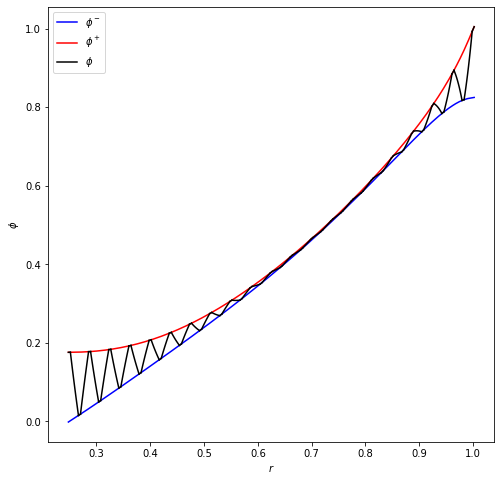

In [10]:
# plot homogenised potential 
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(r_total_mesh, phi_n(x=r_total_mesh), 'b', label=r"$\phi^-$")
ax.plot(r_total_mesh, phi_p(x=r_total_mesh), 'r', label=r"$\phi^+$")
for i in range(len(tt)):
    ax.plot(r_mesh_pos[i,:], phi_p(x=r_mesh_pos[i,:]), 'k', label=r"$\phi$" if i ==0 else "")
for i in range(len(tt)-1):
    ax.plot(r_mesh_neg[i,:], phi_n(x=r_mesh_neg[i,:]), 'k')
    ax.plot(r_mesh_am1[i,:], phi_am1(r_mesh_am1[i,:], tt[i]), 'k')
    ax.plot(r_mesh_am2[i,:], phi_am2(r_mesh_am2[i,:], tt[i]), 'k')
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\phi$")
ax.legend();